In [1]:

import torch
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from torch.utils.data import DataLoader
from torchmeta.modules import MetaModule
import sys
import os
    
from autoint.session import Session
import autoint.autograd_modules as autoint


In [2]:
import numpy as np

def cv_monte_carlo_integration(f, cv_fn, g_integral, domain, n_samples, device):
    """
    Monte Carlo integration with control variates.

    Args:
        f (function): The target function to integrate.
        g (function): Control variate function, closely resembling f.
        g_integral (float): Analytical integral of the control variate g over the domain.
        domain (tuple): The integration domain (start, end).
        n_samples (int): Number of samples.

    Returns:
        float: Estimated integral of f.
    """
    start, end = domain
    # Generate random samples in the domain
    samples = torch.rand(n_samples) * (end - start) + start
    # Compute the function values
    f_values = f(samples)
    g_values =  cv_fn.compute_graph_fast2({'x_coords': samples.to(device).view(-1,1), 'params': None})
    

    # Monte Carlo estimate with control variates
    integral_estimate = g_integral + (end - start) * np.mean(f_values - g_values)
    return integral_estimate

def cos_fn(coords):
  return torch.cos(10*coords)

def polynomial_fn(coords):
    return .1*coords**5 - .2*coords**4 + .2*coords**3 - .4*coords**2 + .1*coords

def sinc_fn(coords):
    coords[coords == 0] += 1
    return torch.div(torch.sin(20*coords), 20*coords)

def linear_fn(coords):
    return 1.0 * coords

def xcosx_fn(coords):
    return coords * torch.cos(coords)

def integral_xcosx_fn(coords):
    return coords*torch.sin(coords) + torch.cos(coords)




boilerplate

In [3]:
class Implicit1DWrapper(torch.utils.data.Dataset):
    def __init__(self, range, fn, grad_fn=None, integral_fn=None, sampling_density=100,
                 train_every=10):

        avg = (range[0] + range[1]) / 2

        coords = self.get_samples(range, sampling_density)
        self.fn_vals = fn(coords)
        self.train_idx = torch.arange(0, coords.shape[0], train_every).float()

        #coords = (coords - avg) / (range[1] - avg)
        self.grid = coords
        self.grid.requires_grad_(True)
        #self.val_grid = val_coords

        if grad_fn is None:
            grid_gt_with_grad = coords
            grid_gt_with_grad.requires_grad_(True)
            fn_vals_with_grad = fn((grid_gt_with_grad * (range[1] - avg)) + avg)
            gt_gradient = torch.autograd.grad(fn_vals_with_grad, [grid_gt_with_grad],
                                              grad_outputs=torch.ones_like(grid_gt_with_grad), create_graph=True,
                                              retain_graph=True)[0]
            try:
                gt_hessian = torch.autograd.grad(gt_gradient, [grid_gt_with_grad],
                                                 grad_outputs=torch.ones_like(gt_gradient), retain_graph=True)[0]
            except Exception as e:
                gt_hessian = torch.zeros_like(gt_gradient)

        else:
            gt_gradient = grad_fn(coords) 
            gt_hessian = torch.zeros_like(gt_gradient)

        self.integral_fn = integral_fn
        if integral_fn:
            self.integral_vals = integral_fn(coords)

        self.gt_gradient = gt_gradient.detach()
        self.gt_hessian = gt_hessian.detach()

    def get_samples(self, range, sampling_density):
        # num = int(range[1] - range[0])*sampling_density
        # avg = (range[0] + range[1]) / 2
        # coords = np.linspace(start=range[0], stop=range[1], num=num)
        # coords.astype(np.float32)
        # coords = torch.Tensor(coords).view(-1, 1)
        coords = torch.rand(sampling_density).view(-1, 1) * (range[1] - range[0]) + range[0]
        return coords

    def get_num_samples(self):
        return self.grid.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if self.integral_fn is not None:
            return {'coords':self.grid}, {'integral_func': self.integral_vals, 'func':self.fn_vals,
                    'gradients':self.gt_gradient, 'val_func': self.val_fn_vals,
                    'val_coords': self.val_grid, 'hessian':self.gt_hessian}
        else:
            return {'idx': self.train_idx, 'coords':self.grid}, \
                   {'func': self.fn_vals, 'gradients':self.gt_gradient,
                    'coords': self.grid}

define cv network

In [4]:
class SIREN(MetaModule):
    def __init__(self, session):
        super().__init__()

        self.net = [] 
        self.input = autoint.Input(torch.Tensor(1, 1), id='x_coords')

        self.net.append(autoint.Linear(1, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 1))

        self.net = torch.nn.Sequential(*self.net)
        self.session = session

    def input_init(self, input_tensor, m):
        with torch.no_grad():
            if isinstance(m, autoint.Input):
                m.set_value(input_tensor, grad=True)

    def constant_init(self, input_tensor, m):
        with torch.no_grad():
            if isinstance(m, autoint.Constant):
                m.set_value(input_tensor, grad=False)
    
    def forward(self, x):
        with torch.no_grad():
            input_init_func = partial(self.input_init, x[:, 0, None])
            self.input.apply(input_init_func)

        input_ctx = autoint.Value(x, self.session)

        out1 = self.input(input_ctx)
        return self.net(out1)

In [5]:
cv_integral = Session()

Creating session: 351175662


In [6]:
net = SIREN(cv_integral)
 #add metal to the mix
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
net.to(device)

SIREN(
  (input): Input()
  (net): Sequential(
    (0): Linear()
    (1): Sine()
    (2): Linear()
    (3): Sine()
    (4): Linear()
    (5): Sine()
    (6): Linear()
    (7): Sine()
    (8): Linear()
  )
  (session): Session()
)

In [7]:
x = torch.ones(1, 1).to(device)# defines a dummy input
y = torch.ones(1, 1).to(device)
x.requires_grad_(True)

session_input = {'x_coords': x,
                 #'y_coords': y,
                 'params': None}

y = net(x)

forward_siren_evaluation = y.data
print(f"result of forward SIREN evaluation={forward_siren_evaluation}")

result of forward SIREN evaluation=tensor([[0.1025]], device='mps:0', grad_fn=<AddBackward0>)


In [8]:
cv_fn = cv_integral.get_backward_graph()

Creating session: 351174717


In [9]:
func_to_fit = integral_xcosx_fn

In [10]:
class loss(torch.nn.Module):
    def __init__(self, U, L):
        super(loss, self).__init__()
        self.error_fn = torch.nn.MSELoss()
        self.U = U
        self.L = L
        # self.func_to_fit = func_to_fit
        self.alpha =0.99

    def l_diff(self, gradnet_outputs, gt):
        return 2*self.error_fn( gradnet_outputs, gt).mean() #L_diff for uniform sampling : the 2 comes from the denominator p_\omega^2
    
    def l_int(self, integralnet_outputs, gt):
        a,b = integralnet_outputs[0], integralnet_outputs[1]
        integral = a-b
        term1 = gt*(self.U-self.L)
        return self.error_fn(integral, term1).mean()
        
    
    def forward(self, integralnet_outputs, gradnet_outputs, gt):
        return self.l_diff(gradnet_outputs=gradnet_outputs, gt=gt) - self.l_int(integralnet_outputs=integralnet_outputs, gt=gt)

Training Loop


In [11]:
U = 10 # upper bound
L = -10 #lower bound


dataset = Implicit1DWrapper([L, U], fn=func_to_fit, \
                            sampling_density=1000, train_every=1)

dataloader = DataLoader(dataset,shuffle=True, batch_size=1, \
                        pin_memory=True, num_workers=0)



def dict2cuda(d):
    tmp = {}
    for key, value in d.items():
        if isinstance(value, torch.Tensor):
            tmp.update({key: value.to(device)})
        else:
            tmp.update({key: value})
    return tmp

In [12]:
bounds_tensor = torch.tensor([[L], [U]], dtype=torch.float32)

# If you're using CUDA:
bounds_tensor = bounds_tensor.to(device)

In [13]:
epochs = 1000

loss_fn = loss(U, L)
optimizer = torch.optim.Adam(lr=5e-6, params=net.parameters(),amsgrad=True)

print_loss_every = 50
losses = []


for e in range(epochs):
  for step, (input, gt) in enumerate(dataloader):
      input = dict2cuda(input)
      gt = dict2cuda(gt)
      
      gradnet_output = cv_fn.compute_graph_fast2({'x_coords': input['coords'],
                                                            'params': None})
      integralnet_output = net(bounds_tensor).data
      loss = loss_fn(integralnet_output, gradnet_output, gt['func'])
      
      optimizer.zero_grad()
      loss.backward()
      losses.append(loss.item())
      optimizer.step()
    
  if not e % print_loss_every:
      print(f"{e}/{epochs}: loss={loss}")

/Users/sekiro/miniconda3/envs/autoint/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1000, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0/1000: loss=-5933.14013671875
50/1000: loss=-5953.68798828125
100/1000: loss=-5965.36328125
150/1000: loss=-5971.28662109375
200/1000: loss=-5975.37158203125
250/1000: loss=-5979.0205078125
300/1000: loss=-5982.42431640625
350/1000: loss=-5985.568359375
400/1000: loss=-5988.583984375
450/1000: loss=-5991.51513671875
500/1000: loss=-5994.37890625
550/1000: loss=-5997.18896484375
600/1000: loss=-5999.9599609375
650/1000: loss=-6002.70751953125
700/1000: loss=-6005.44384765625
750/1000: loss=-6008.17822265625
800/1000: loss=-6010.912109375
850/1000: loss=-6013.64599609375
900/1000: loss=-6016.376953125
950/1000: loss=-6019.11279296875


Text(0.5, 1.0, 'Loss vs Epoch for SIREN')

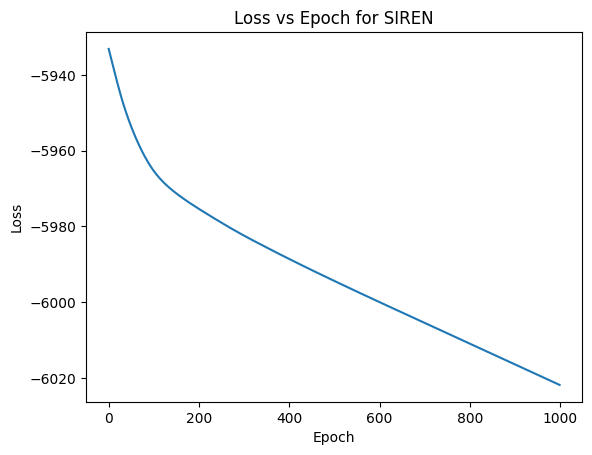

In [14]:
plt.plot(np.arange(0,epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for SIREN')

Text(0.5, 1.0, 'NCV+AD siren, L_diff-L_int')

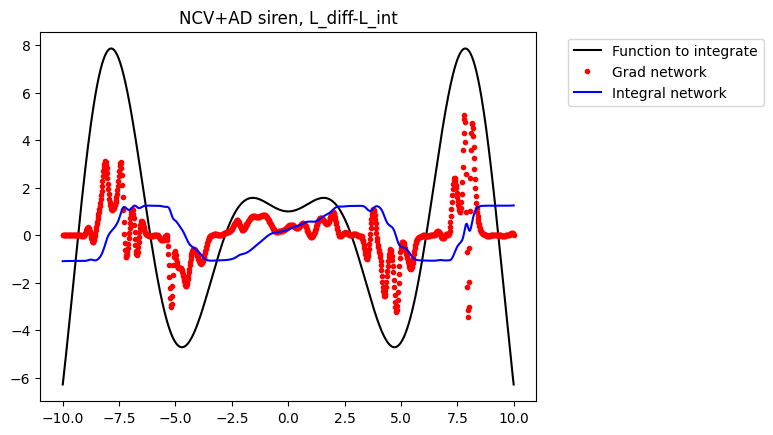

In [19]:
x_coords = torch.linspace(L,U,1000)[:,None].to(device)
grad_vals = func_to_fit(x_coords).cpu()
fitted_grad_vals = cv_fn.compute_graph_fast2({'x_coords': x_coords,
                                                       'params': None}).cpu()
integral_vals = cv_integral.compute_graph_fast2({'x_coords': x_coords,
                                                        'params': None}).cpu()

x_coords = x_coords.cpu()
plt.plot(x_coords,grad_vals,'-k', label='Function to integrate')
plt.plot(x_coords,fitted_grad_vals.detach(),'.r', label='Grad network')
plt.plot(x_coords,integral_vals.detach(),'-b', label='Integral network')
# plt.plot(x_coords,grad_vals-fitted_grad_vals.detach(),'-g', label='Error grad')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('NCV+AD siren, L_diff-L_int')


In [16]:
integralnet_output = cv_integral.compute_graph_fast2({'x_coords': bounds_tensor, 'params': None})
g_integral =  integralnet_output[1]- integralnet_output[0] # Analytical integral of g(x) over [0, pi]

# Integration domain and sample count
domain = (L,U)
n_samples = 10000

# Perform the integration
result = cv_monte_carlo_integration(func_to_fit, cv_integral, g_integral, domain, n_samples,device=device)
print(f"Estimated integral of f(x): {result}")


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!